## Lab 5.0 – Polyp segmentaton: YOLO8 (Ultralytics hub)
This notebook is used to evaluate the performance of polyp segmentaton models trained on Ultralytics hub.

This example code will consist of:

1. **Setup**
2. **Load Dataset**
3. **Train Model**
4. **Inference & Evaluate**

## 1) Setup
The code below install and import all required libraries and defines utility functions that will be used in the rest of this notebook.

In [ ]:
# Download library
!pip install ultralytics opencv-python tqdm matplotlib -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 25.1 MB/s eta 0:00:00


In [ ]:
# Import library
import os
import shutil
import yaml
import time
import random
from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from IPython.display import Video
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## 2) Load Dataset
In this step, the dataset is downloaded from GitHub. The dataset structure is prepared in a format compatible with YOLO. Please refer to the following paths: /content/polyp_seg/

In [ ]:
!wget https://github.com/pvateekul/digitalhealth-ai2025/raw/main/code/Class05_MONAI/polyp_seg.zip
!wget https://github.com/pvateekul/digitalhealth-ai2025/raw/main/code/Class05_MONAI/masks.zip
!unzip -q -o 'polyp_seg.zip'
!unzip -q -o 'masks.zip'

--2026-01-10 14:25:49--  https://github.com/pvateekul/digitalhealth-ai2025/raw/main/code/Class05_MONAI/polyp_seg.zip
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/pvateekul/digitalhealth-ai2025/main/code/Class05_MONAI/polyp_seg.zip [following]
--2026-01-10 14:25:49--  https://media.githubusercontent.com/media/pvateekul/digitalhealth-ai2025/main/code/Class05_MONAI/polyp_seg.zip
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34351229 (33M) [application/zip]
Saving to: ‘polyp_seg.zip’

polyp_seg.zip       100%[===================>]  32.76M  61.6MB/s    in 0.5s    

2026-01-10 14:

## 3) Load Model
Load models trained on ultralytics hub

In [ ]:
# Upload the pt file exported from ultralytics hub
#!wget https://github.com/pvateekul/digitalhealth-ai2025/raw/main/code/Class04_YOLO/YOLOv8_polyp_segmentation.pt # Comment this line if you want to upload your own file.
#model = YOLO("YOLOv8_polyp_segmentation.pt")
model = YOLO("your_model")

## 4) Inference & Evaluate


0: 320x320 1 polyp, 60.8ms
Speed: 9.0ms preprocess, 60.8ms inference, 26.7ms postprocess per image at shape (1, 3, 320, 320)


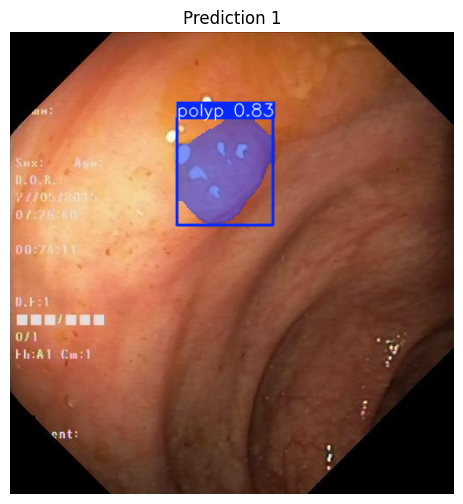

In [ ]:
# Inference (image)
test_imgs = glob("polyp_seg/images/test/*.jpg")[:1]
results = model.predict(test_imgs, conf=0.3)

for i, r in enumerate(results):
    img = r.plot()[:, :, ::-1]
    plt.figure(figsize=(10, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediction {i+1}")
    plt.show()

In [ ]:
# results(Boxes)
results[0].boxes.data # [x1,y1,x2,y2, confidence score,class]

tensor([[191.5835,  98.4872, 301.2498, 221.3156,   0.8293,   0.0000]], device='cuda:0')

(np.float64(-0.5), np.float64(319.5), np.float64(319.5), np.float64(-0.5))

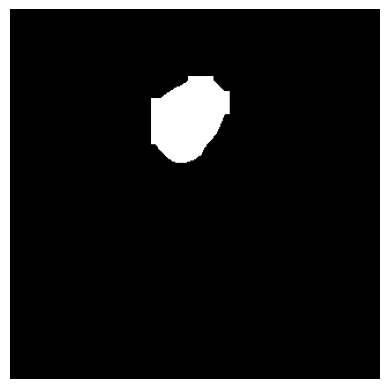

In [ ]:
# results(Masks)
img = results[0].masks.data.cpu().numpy()[0]
plt.imshow(img, cmap="gray")
plt.axis("off")

In [ ]:
def calc_iou_dice(pred_mask, gt_mask, thr=0.5):
    pred_bin = (pred_mask > thr).astype(np.uint8)
    gt_bin = (gt_mask > 0.5).astype(np.uint8)
    inter = np.logical_and(pred_bin, gt_bin).sum()
    union = np.logical_or(pred_bin, gt_bin).sum()
    iou = inter / (union + 1e-8)
    dice = 2 * inter / (pred_bin.sum() + gt_mask.sum() + 1e-8)
    return iou, dice

In [ ]:
test_imgs = glob("polyp_seg/images/test/*.jpg") + glob("polyp_seg/images/test/*.png")
mask_dir = "/content/masks"
print(f"Testing {len(test_imgs)} validation images...")

ious, dices, times = [], [], []

for img_path in tqdm(test_imgs, desc="Evaluating YOLOv8"):
    img = cv2.imread(img_path)
    if img is None:
        print(f"Cannot read image: {img_path}")
        continue

    # Inference
    start = time.time()
    results = model.predict(img, conf=0.3, verbose=False)
    times.append(time.time() - start)

    if results[0].masks is None or len(results[0].masks.data) == 0:
        continue

    pred_mask = results[0].masks.data[0].cpu().numpy()
    pred_mask = cv2.resize(pred_mask, (img.shape[1], img.shape[0]))

    # mask ground-truth
    mask_path = None
    img_name = os.path.basename(img_path)
    for ext in [".png", ".jpg", ".jpeg", ".bmp"]:
        candidate = os.path.join(mask_dir, os.path.splitext(img_name)[0] + ext)
        if os.path.exists(candidate):
            mask_path = candidate
            break
    if mask_path is None:
        print(f"Cannot find mask for: {img_name}")
        continue

    mask_gt = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask_gt is None:
        print(f"Cannot read mask: {mask_path}")
        continue
    mask_gt = (mask_gt > 127).astype(np.float32)

    i, d = calc_iou_dice(pred_mask, mask_gt)
    ious.append(i)
    dices.append(d)

print(f"\n YOLOv8 Performance:")
print(f"• Mean IoU:  {np.mean(ious):.4f}")
print(f"• Mean Dice: {np.mean(dices):.4f}")
print(f"• Avg inference time: {np.mean(times)*1000:.2f} ms/img")


Testing 100 validation images...


Evaluating YOLOv8: 100%|██████████| 100/100 [00:01<00:00, 71.44it/s]


 YOLOv8 Performance:
• Mean IoU:  0.8127
• Mean Dice: 0.8815
• Avg inference time: 10.06 ms/img


In [ ]:
# Download video
!wget https://github.com/pvateekul/digitalhealth-ai2025/raw/main/code/Class04_YOLO/video.mp4

--2026-01-10 14:52:42--  https://github.com/pvateekul/digitalhealth-ai2025/raw/main/code/Class04_YOLO/video.mp4
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pvateekul/digitalhealth-ai2025/main/code/Class04_YOLO/video.mp4 [following]
--2026-01-10 14:52:42--  https://raw.githubusercontent.com/pvateekul/digitalhealth-ai2025/main/code/Class04_YOLO/video.mp4
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4496629 (4.3M) [application/octet-stream]
Saving to: ‘video.mp4’

video.mp4           100%[===================>]   4.29M  --.-KB/s    in 0.04s   

2026-01-10 14:52:42 (106 MB/s) - ‘video.mp4’ sav

In [ ]:
cap = cv2.VideoCapture("video.mp4")

w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

out = cv2.VideoWriter(
    "output.mp4",
    cv2.VideoWriter_fourcc(*"mp4v"),
    fps,
    (w, h)
)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    results = model(frame, conf=0.3)[0]

    annotated = results.plot()  # วาด bbox
    out.write(annotated)

cap.release()
out.release()

In [ ]:
!ffmpeg -i /content/output.mp4 -vcodec libx264 -acodec aac /content/output_fixed.mp4

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [ ]:
Video("output_fixed.mp4", embed=True)

In [ ]:
Video("output_fixed.mp4", embed=True)